<a href="https://colab.research.google.com/github/mlubega/cv/blob/master/DetectNum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OCR

Maimuna Lubega

April 2019

### Please execute each cell in order to install and load the necessary libraries and functions.

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Install necessary libraries

!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16
!pip install matplotlib
!pip install numpy
!pip install pandas

In [0]:
# Install required dependencies before installing Tesseract and Pytesseract
!apt install libleptonica-dev # 
!apt install libtesseract-dev
!apt install tesseract-ocr
!pip install pytesseract

In [0]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import imutils
import sys
import argparse
import os
from google.colab.patches import cv2_imshow



IMG_EXTS = ['.jpg', '.jpeg']
VID_EXTS = ['.mp4', '.mov']
VALID_LIST = IMG_EXTS + VID_EXTS

In [0]:
'''
get_image()

This method accepts only four file types ['.mp4', '.mov','.jpg','.jpeg' ]

input: filepath
output: image or single frame for video


'''

def get_image(filepath):

  if not filepath:
    raise ValueError("No file path given")

  img = None
  ftype = os.path.splitext(filepath)[-1]


  # process img
  if ftype in IMG_EXTS:
      img = cv2.imread(filepath)

  #process video
  elif ftype in VID_EXTS: 
      cap = cv2.VideoCapture(filepath)

      if not cap.isOpened:
          sys.exit('Video Capture Not Open')  # how to handle?

      total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
      for i in range(total_frames):
          hasframe, frame = cap.read()

          if not hasframe:
               continue;
          if filepath.endswith('.mov'):
               frame = imutils.rotate_bound(frame, 90)

          img = frame
          break;
  else:
      raise ValueError("Invalid file extension")
      
  if img == None:
    raise FileNotFoundError("Unable to read file")

  return img

In [0]:
'''
get_mser_regions()


input: image
output: array with identified mser regions

'''
def get_mser_regions(img):
    
    rois = []
     
    #Set params
    img_height, img_width = img.shape[:2]
    img_area = float(img_height) * img_width
    max_num_area = int(img_area * 0.004)
    kernel_edge = int(np.sqrt(max_num_area / 2))
    

    # Threshold
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    retval, graythresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Opening
    kernel = np.ones((kernel_edge,kernel_edge),np.uint8)
    opening = cv2.morphologyEx(graythresh, cv2.MORPH_OPEN, kernel)

    #extract MSER regions
    vis = img.copy()
    mser = cv2.MSER_create(_delta=10, _max_area=max_num_area, _max_variation=0.5)
    regions, _ = mser.detectRegions(opening)
    for p in regions:
        xmax, ymax = np.amax(p, axis=0)
        xmin, ymin = np.amin(p, axis=0)
        
        # increasing bbox improves detection & recognition
        xmax = min(xmax + 35, img_width )
        ymax = min(ymax + 35, img_height)
        xmin = max(xmin - 35, 1)
        ymin = max(ymin - 35, 1)
    
    
        rois.append(img[ymin:ymax, xmin:xmax])
        cv2.rectangle(vis, (xmin,ymax), (xmax,ymin), (0, 255, 0), 1)

    
    return rois

In [0]:
'''
get_best_roi()

This method converts the image to grayscale, generates a histogram of 16 bins,
and sums the first and last four bins. If the sum of those values is 88% or more 
of the total values, then the histogram is bimodal, likely contains text, and will
be returned as the best roi. Is there is more than one bimodal histogram, it will 
return the one with the highest percentage

input: list of roi regions
output: single roi that is above the threshold

'''
def get_best_roi(rois):
    

    best_roi = None
    best_pct = .88 # bad practice, sorry
    
    for img in rois:

      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      
      #filtering using histogram
      hist,bins = np.histogram(gray.ravel(),16)
      low = sum(hist[:4])
      high = sum(hist[12:])
      al = sum(hist)
      bimodal_pct = (low+high)/al
      
      if bimodal_pct > best_pct:
          best_roi = img
          best_pct = bimodal_pct

    
    return best_roi

In [0]:
'''
deskew_image

This code is taken from ( https://www.pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/ ) 

input: rgbimage
output: rgb image
'''
def deskew_image(img):
    g_roi = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(g_roi)

    # threshold the image, setting all foreground pixels to
    # 255 and all background pixels to 0
    thresh = cv2.threshold(gray, 0, 255,
    	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    
    # grab the (x, y) coordinates of all pixel values that
    # are greater than zero, then use these coordinates to
    # compute a rotated bounding box that contains all
    # coordinates
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]

     
    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle trends to 0 -- in this special case we
    # need to add 90 degrees to the angle
    if angle < -45:
    	angle = -(90 + angle)
 
    # # otherwise, just take the inverse of the angle to make
    # # it positive
    else:
    	angle = -angle


    # rotate the image to deskew it
    image = img
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
    	flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    

    return rotated
 




In [0]:
'''
binarize()

This methods returns a binary image.

input: binary image
output: string text
'''
def binarize(img):
  ret, thresh1 = cv2.threshold(img, 150,255,cv2.THRESH_BINARY)

  return thresh1

'''
read_text()

This methods uses the pytesseract library to recognize text in the image.
The configuration specifies:

  -l eng = english language
  --oem 3 = Default engine( i.e. LSTM) , based on what is available.
  --psm 7 = Assume text is a single line
  --outputbase digits = return only digits ( not functional)

input: binary image
output: string text
'''

def read_text(img):
    
  config = ("-l eng --oem 3 --psm 7  outputbase digits")
  text = pytesseract.image_to_string(img, config=config) 

  return text

In [0]:
'''
detect_num
'''

def detect_num(filename):

    img = get_image(filename)
    if img is None:
      return 
    rois = get_mser_regions(img)
    roi = get_best_roi(rois)
    if roi is None:
      return "No text regions detected"
    
    rotated = deskew_image(roi)
    bw_img = binarize(rotated)
    cv2_imshow(bw_img)
    text = read_text(bw_img)
    return text

###  Add images and videos  you want to test to the images folder. Executing the cell below will loop over the folder and print detected text if any. If you have downloaded this file to your own Google Drive, then please modify the image_dir to point to the directory where you have kept the images.

No text regions detected detected for image: juan.jpg


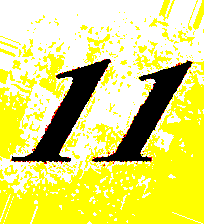

TT detected for image: jack_side.jpeg


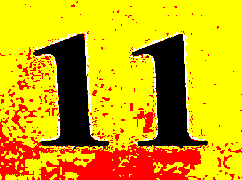

11 detected for image: jack.jpeg


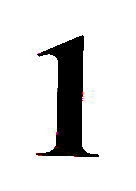

1 detected for image: sepher.jpg


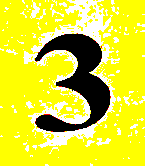

 detected for image: daniel.jpeg


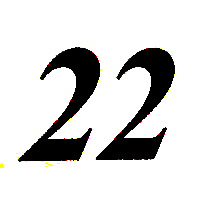

22 detected for image: sophie_side.jpeg


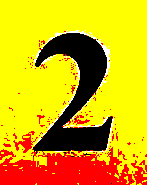

2 detected for image: elia.jpeg


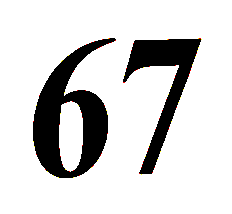

67 detected for image: juan_full.jpg


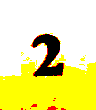

2 detected for image: elia_vid.mov


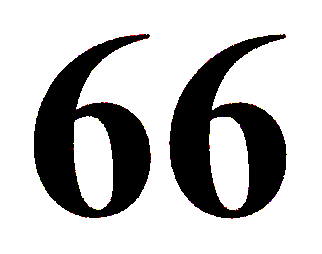

66 detected for image: eijaz.jpg


In [0]:
img_dir = "/content/drive/My Drive/City Msc Data Science/ComputerVision/Coursework2019/images"


file_names = os.listdir(img_dir)
image_names = list(filter(lambda x: os.path.splitext(x)[1] in VALID_LIST, file_names)) # remove invalid file extensions

for name in image_names:
    file_path = os.path.join(img_dir, name)
    detected_text = detect_num(file_path)
    print(detected_text, "detected for image:", name)